In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.nn.functional import cross_entropy

In [2]:
#####################################
# Configuration and Hyperparameters
#####################################
images_path = "/kaggle/input/flickr8k/Images"
captions_file = "/kaggle/input/flickr8k/captions.txt"
BATCH_SIZE = 8   # smaller batch due to memory constraints of large model
NUM_EPOCHS = 1   # set to 1 for demonstration; increase for real training
LEARNING_RATE = 1e-5
MAX_SEQ_LEN = 30  # BLIP will handle truncation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
blip_model = BlipForConditionalGeneration.from_pretrained(model_name).to(DEVICE)

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [4]:
# We will freeze most of BLIP's layers if desired, or keep them trainable.
# For now, let's keep them trainable for demonstration.
for param in blip_model.parameters():
    param.requires_grad = True

In [5]:
from torch.utils.data import Dataset
from PIL import Image
import os

class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, df, processor, max_length=30):
        """
        Args:
            image_dir: Directory with Flickr8k images
            df: A pandas DataFrame with columns 'image' and 'caption'
            processor: A BlipProcessor for image and text
            max_length: Maximum sequence length for captions
        """
        self.image_dir = image_dir
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']
        caption = row['caption']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Process image and caption using BLIP processor
        inputs = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=self.max_length
        )
        
        # The processor returns a batch dimension even for a single sample, so we remove it.
        pixel_values = inputs.pixel_values.squeeze(0)       # (3, 224, 224)
        input_ids = inputs.input_ids.squeeze(0)             # (max_length,)
        attention_mask = inputs.attention_mask.squeeze(0)   # (max_length,)

        # Return everything needed by the model
        return pixel_values, input_ids, attention_mask

In [6]:
# Load the captions DataFrame
df = pd.read_csv(captions_file)   # contains 'image' and 'caption' columns

In [7]:
df.shape

(40455, 2)

In [8]:
# limit dataset size
ratio = 0.15

In [9]:
# limit ds to partial
df = df.iloc[:int(ratio * df.shape[0])]  # Limit to 50% of the rows

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.utils.data import DataLoader, Subset

# Split into train, val, and test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 50% val, 50% test from temp

# Log dataset sizes
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

# Create datasets for each split
train_dataset = Flickr8kDataset(
    image_dir=images_path,
    df=train_df,
    processor=processor,
    max_length=MAX_SEQ_LEN
)

val_dataset = Flickr8kDataset(
    image_dir=images_path,
    df=val_df,
    processor=processor,
    max_length=MAX_SEQ_LEN
)

test_dataset = Flickr8kDataset(
    image_dir=images_path,
    df=test_df,
    processor=processor,
    max_length=MAX_SEQ_LEN
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)

Train size: 4247, Val size: 910, Test size: 911


In [14]:
#####################################
# Refinement and Alignment Layers
#####################################
class CaptionRefinementNetwork(nn.Module):
    def __init__(self, d_model, num_layers=1, num_heads=4, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, caption_embeds, caption_mask=None):
        refined = self.transformer_encoder(caption_embeds, src_key_padding_mask=caption_mask)
        return refined

class SemanticAlignmentLayer(nn.Module):
    def __init__(self, d_model, num_heads=4, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.cross_attn_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
    def forward(self, caption_embeds, image_embeds, caption_mask=None, image_mask=None):
        aligned = self.cross_attn_layer(tgt=caption_embeds, memory=image_embeds,
                                        tgt_key_padding_mask=caption_mask,
                                        memory_key_padding_mask=image_mask)
        return aligned

In [15]:
D_MODEL = blip_model.config.text_config.hidden_size  # Use the BLIP text hidden size
refinement_network = CaptionRefinementNetwork(
    d_model=D_MODEL,
    num_layers=1,
    num_heads=4,
    dim_feedforward=1024,
    dropout=0.1
).to(DEVICE)

alignment_layer = SemanticAlignmentLayer(
    d_model=D_MODEL,
    num_heads=4,
    dim_feedforward=1024,
    dropout=0.1
).to(DEVICE)

# We'll create an optimizer that includes our new layers and the BLIP model parameters
params = list(blip_model.parameters()) + list(refinement_network.parameters()) + list(alignment_layer.parameters())
optimizer = optim.AdamW(params, lr=LEARNING_RATE)

In [16]:
import torch
import torch.nn as nn

class CombinedCaptioningModel(nn.Module):
    def __init__(self, base_blip_model, refinement_network, alignment_layer, processor, device="cuda"):
        super().__init__()
        self.model = base_blip_model
        self.refinement_network = refinement_network
        self.alignment_layer = alignment_layer
        self.processor = processor
        self.device = device

        self.d_model = self.model.config.text_config.hidden_size
        self.max_position_embeddings = self.model.config.text_config.max_position_embeddings

        # For convenience, get special tokens (modify as needed)
        self.bos_token_id = self.processor.tokenizer.cls_token_id
        self.eos_token_id = self.processor.tokenizer.sep_token_id
        self.pad_token_id = self.processor.tokenizer.pad_token_id

        # Move to device if not already
        self.to(self.device)

    def forward(self, pixel_values, input_ids, attention_mask):
        """
        Forward pass for the CombinedCaptioningModel.
        Mimics the separated model logic for refinement and alignment.
        """
        # Step 1: Extract image embeddings
        outputs = self.model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True,
        )
        decoder_hidden_states = outputs.hidden_states[-1]  # (B, T, D_MODEL)
        image_embeds = outputs.image_embeds  # (B, img_seq_len, D_MODEL)
    
        # Step 2: Create a valid token mask for the caption length
        seq_len = decoder_hidden_states.size(1)
        valid_token_mask = torch.zeros(
            (input_ids.size(0), seq_len), dtype=torch.bool, device=decoder_hidden_states.device
        )
        valid_token_mask[:, :input_ids.size(1)] = True  # Mark tokens up to caption length as valid
    
        # Step 3: Refine the decoder hidden states
        refined_embeds = self.refinement_network(
            decoder_hidden_states, caption_mask=valid_token_mask
        )
    
        # Step 4: Align refined embeddings with image embeddings
        aligned_embeds = self.alignment_layer(
            refined_embeds, image_embeds, caption_mask=valid_token_mask
        )
    
        # Step 5: Truncate aligned embeddings to the maximum allowable sequence length
        max_seq_len = self.model.config.text_config.max_position_embeddings  # Typically 512
        aligned_embeds = aligned_embeds[:, :max_seq_len, :]  # (B, max_seq_len, D_MODEL)
    
        # Step 6: Truncate the mask as well
        valid_token_mask = valid_token_mask[:, :max_seq_len]
    
        # Step 7: Project to logits using the text decoder
        logits = self.model.text_decoder(
            inputs_embeds=aligned_embeds,
            attention_mask=valid_token_mask,
            return_dict=True,
        ).logits  # (B, T, vocab_size)
    
        return logits


    def generate(self, pixel_values, max_length=30, num_beams=1):
        """
        Custom generation loop that uses refinement and alignment at each decoding step.
        Note: Beam search can be complicated to integrate manually, so we use greedy decoding here.
        Integrate beam search if needed.

        Steps:
        1. Encode image once with model.vision_model.
        2. Start with BOS token.
        3. Autoregressively decode:
           - Call text_decoder to get decoder_hidden_states
           - Refine & align
           - Predict next token
           - Stop at EOS or max_length
        """

        self.eval()  # Ensure model is in eval mode

        pixel_values = pixel_values.to(self.device)
        with torch.no_grad():
            # Compute image embeddings once
            vision_outputs = self.model.vision_model(pixel_values=pixel_values)
            image_embeds = vision_outputs[0]  # (B, img_seq_len, D_MODEL)

            batch_size = pixel_values.size(0)

            # Initialize input_ids with BOS token
            input_ids = torch.full(
                (batch_size, 1), self.bos_token_id, device=self.device, dtype=torch.long
            )

            for step in range(max_length):
                # Run text_decoder to get hidden_states
                # Here we must get hidden states to refine & align
                decoder_outputs = self.model.text_decoder(
                    input_ids=input_ids,
                    encoder_hidden_states=image_embeds,
                    output_hidden_states=True,
                    return_dict=True
                )

                # Extract the last hidden states
                decoder_hidden_states = decoder_outputs.hidden_states[-1]  # (B, T, d_model)
                seq_len = decoder_hidden_states.size(1)

                # All tokens so far are valid
                valid_token_mask = torch.ones((batch_size, seq_len), dtype=torch.bool, device=self.device)

                # Refinement
                refined_embeds = self.refinement_network(decoder_hidden_states, caption_mask=valid_token_mask)

                # Alignment
                aligned_embeds = self.alignment_layer(refined_embeds, image_embeds, caption_mask=valid_token_mask)

                # Truncate if needed
                max_seq_len = self.max_position_embeddings
                if aligned_embeds.size(1) > max_seq_len:
                    aligned_embeds = aligned_embeds[:, :max_seq_len, :]
                    valid_token_mask = valid_token_mask[:, :max_seq_len]

                # Get logits from aligned embeddings
                # aligned_embeds shape: (B, T, d_model), we need next token from last position T-1
                # We'll just take the last token embedding to predict next token
                last_token_embeds = aligned_embeds[:, -1:, :]  # (B, 1, d_model)
                logits = self.model.lm_head(last_token_embeds)  # (B, 1, vocab_size)

                # Greedy decoding: pick the most probable token at the last step
                next_token_ids = logits[:, -1, :].argmax(dim=-1)  # (B,)

                # Check for EOS
                if (next_token_ids == self.eos_token_id).all():
                    break

                # Append the generated token
                input_ids = torch.cat([input_ids, next_token_ids.unsqueeze(-1)], dim=-1)

            # Decode the generated sequences
            captions = self.processor.tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            return captions

In [15]:
from tqdm import tqdm
import os
import torch

def train_combined_model(
    combined_model,
    train_loader,
    val_loader,
    processor,
    optimizer,
    device="cuda",
    num_epochs=5,
    save_path="./best_model.pt"
):
    """
    Trains the CombinedCaptioningModel that encapsulates the BLIP model, refinement network, and alignment layer.
    
    Args:
        combined_model: An instance of CombinedCaptioningModel that returns logits given (pixel_values, input_ids, attention_mask).
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        processor: BLIP processor for tokenization details (to get pad_token_id).
        optimizer: Optimizer for model training.
        device: Device to run training on ("cuda" or "cpu").
        num_epochs: Number of training epochs.
        save_path: Path to save the best model.
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    best_val_loss = float("inf")

    combined_model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        
        # Training Phase
        combined_model.train()

        total_train_loss = 0.0
        train_progress = tqdm(train_loader, desc="Training", leave=False)
        for pixel_values, input_ids, attention_mask in train_progress:
            pixel_values = pixel_values.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Forward pass through the combined model
            # combined_model should return logits of shape (B, T, vocab_size)
            logits = combined_model(pixel_values, input_ids, attention_mask)

            # Compute loss
            # Shift labels to the right by 1
            labels = input_ids[:, 1:].contiguous()  # next-token prediction
            # Align logits with labels length
            pred_logits = logits[:, :labels.size(1), :].contiguous()

            # Compute cross-entropy loss, ignoring pad tokens
            loss_fn = torch.nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)
            loss = loss_fn(pred_logits.view(-1, logits.size(-1)), labels.view(-1))

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update loss
            total_train_loss += loss.item()
            train_progress.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation Phase
        combined_model.eval()

        total_val_loss = 0.0
        val_progress = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for pixel_values, input_ids, attention_mask in val_progress:
                pixel_values = pixel_values.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                # Forward pass
                logits = combined_model(pixel_values, input_ids, attention_mask)

                # Compute validation loss
                labels = input_ids[:, 1:].contiguous()
                pred_logits = logits[:, :labels.size(1), :].contiguous()

                loss_fn = torch.nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)
                val_loss = loss_fn(pred_logits.view(-1, logits.size(-1)), labels.view(-1))

                total_val_loss += val_loss.item()
                val_progress.set_postfix(loss=val_loss.item())

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save entire combined model state and optimizer
            torch.save(
                {
                    "combined_model_state_dict": combined_model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": avg_val_loss,
                },
                save_path,
            )
            print(f"New best model saved with Validation Loss: {avg_val_loss:.4f}")

    print("Training completed.")

In [25]:
# Initialize CombinedCaptioningModel
combined_model = CombinedCaptioningModel(blip_model, refinement_network, alignment_layer, processor)

In [26]:
combined_model = torch.nn.DataParallel(combined_model)  # Wrap model for multi-GPU
combined_model = combined_model.to("cuda")  # Move model to GPU

In [18]:
# Define optimizer for the combined model
optimizer = torch.optim.AdamW(
    combined_model.parameters(),  # All parameters of the combined model
    lr=1e-5
)

start training

In [16]:
# Call the updated training function
train_combined_model(
    combined_model=combined_model,  # Pass the combined model
    train_loader=train_loader,
    val_loader=val_loader,
    processor=processor,
    optimizer=optimizer,
    device="cuda",
    num_epochs=5,
    save_path="./best_model.pt",
)

Epoch [1/5]


Epoch [1/5], Train Loss: 5.4461


Epoch [1/5], Validation Loss: 4.6931
New best model saved with Validation Loss: 4.6931
Epoch [2/5]


Epoch [2/5], Train Loss: 4.5063


Epoch [2/5], Validation Loss: 4.4609
New best model saved with Validation Loss: 4.4609
Epoch [3/5]


Epoch [3/5], Train Loss: 4.2749


Epoch [3/5], Validation Loss: 4.3453
New best model saved with Validation Loss: 4.3453
Epoch [4/5]


Epoch [4/5], Train Loss: 4.1117


Epoch [4/5], Validation Loss: 4.3123
New best model saved with Validation Loss: 4.3123
Epoch [5/5]


Epoch [5/5], Train Loss: 3.9945


Epoch [5/5], Validation Loss: 4.2513
New best model saved with Validation Loss: 4.2513
Training completed.


Download best model (then upload to kaggle dataset):

In [24]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')  # Change to the working directory
    zip_name = f"/kaggle/working/{download_file_name}.zip"  # Define zip file name
    command = f"zip {zip_name} {path} -r"  # Create zip command
    result = subprocess.run(command, shell=True, capture_output=True, text=True)  # Run zip command
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))  # Display download link

# Path to your model
path = "/kaggle/working/best_model.pt"  # Relative path to model
download_file_name = "10_epochs_18.12_model"  # Name for the zip file

# Call the function to zip and create a download link
download_file(path, download_file_name)

/kaggle/working/10_epochs_18.12_model.zip

In [18]:
pip install rouge_scorer

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: Could not find a version that satisfies the requirement rouge_scorer (from versions: none)
ERROR: No matching distribution found for rouge_scorer
Note: you may need to restart the kernel to use updated packages.


In [19]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import torch

def evaluate_model(combined_model, test_loader, processor, device="cuda"):
    """
    Evaluates the combined_model on the test_loader using BLEU and ROUGE metrics.
    
    Args:
        combined_model: The CombinedCaptioningModel (in evaluation mode) with a .generate() method implemented.
        test_loader: DataLoader for the test set.
        processor: The BLIP processor used for tokenization details.
        device: The device on which model inference will be performed.

    Prints:
        BLEU-4 and ROUGE (rouge1, rouge2, rougeL) metrics.
    """

    combined_model.eval()  # Ensure model is in evaluation mode
    
    # Containers for references and hypotheses
    ground_truth_captions = []
    generated_captions = []

    # Helper function to decode captions
    def decode_captions(input_ids, processor):
        return processor.tokenizer.batch_decode(input_ids, skip_special_tokens=True)

    with torch.no_grad():
        for pixel_values, input_ids, attention_mask in test_loader:
            pixel_values = pixel_values.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Generate captions from the model
            generated_ids = combined_model.generate(
                pixel_values=pixel_values,
                max_length=30,
                num_beams=5,
                early_stopping=True
            )

            # Decode ground truth and generated captions
            ground_truth_captions.extend(decode_captions(input_ids, processor))
            generated_captions.extend(decode_captions(generated_ids, processor))

    # Initialize scorers
    smooth = SmoothingFunction().method4
    rouge_scorer_inst = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    bleu_scores = []
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    # Compute metrics
    for gt, gen in zip(ground_truth_captions, generated_captions):
        reference = [gt.split()]
        hypothesis = gen.split()
        
        # BLEU
        bleu = sentence_bleu(reference, hypothesis, smoothing_function=smooth)
        bleu_scores.append(bleu)
        
        # ROUGE
        scores = rouge_scorer_inst.score(gt, gen)
        for key in rouge_scores.keys():
            rouge_scores[key].append(scores[key].fmeasure)

    # Aggregate scores
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    avg_rouge = {key: sum(values) / len(values) if values else 0.0 for key, values in rouge_scores.items()}

    # Print results
    print("Evaluation Results:")
    print(f"BLEU-4: {avg_bleu:.4f}")
    for key, value in avg_rouge.items():
        print(f"{key.upper()}: {value:.4f}")

ModuleNotFoundError: No module named 'rouge_score'

In [21]:
# Call the updated training function
train_combined_model(
    combined_model=combined_model,  # Pass the combined model
    train_loader=train_loader,
    val_loader=val_loader,
    processor=processor,
    optimizer=optimizer,
    device="cuda",
    num_epochs=5,
    save_path="./best_model.pt",
)

Epoch [1/5]


Epoch [1/5], Train Loss: 3.8705


Epoch [1/5], Validation Loss: 4.2306
New best model saved with Validation Loss: 4.2306
Epoch [2/5]


Epoch [2/5], Train Loss: 3.7514


Epoch [2/5], Validation Loss: 4.1883
New best model saved with Validation Loss: 4.1883
Epoch [3/5]


Epoch [3/5], Train Loss: 3.6647


Epoch [3/5], Validation Loss: 4.1755
New best model saved with Validation Loss: 4.1755
Epoch [4/5]


Epoch [4/5], Train Loss: 3.5848


Epoch [4/5], Validation Loss: 4.2047
Epoch [5/5]


Epoch [5/5], Train Loss: 3.5064


Epoch [5/5], Validation Loss: 4.1973
Training completed.


In [25]:
train_combined_model(
    combined_model=combined_model,  # Pass the combined model
    train_loader=train_loader,
    val_loader=val_loader,
    processor=processor,
    optimizer=optimizer,
    device="cuda",
    num_epochs=5,
    save_path="./best_model.pt",
)

Epoch [1/5]


Epoch [1/5], Train Loss: 3.4380


Epoch [1/5], Validation Loss: 4.1875
New best model saved with Validation Loss: 4.1875
Epoch [2/5]


Epoch [2/5], Train Loss: 3.3622


Epoch [2/5], Validation Loss: 4.2037
Epoch [3/5]


Epoch [3/5], Train Loss: 3.3030


Epoch [3/5], Validation Loss: 4.2164
Epoch [4/5]


Epoch [4/5], Train Loss: 3.2444


Epoch [4/5], Validation Loss: 4.2270
Epoch [5/5]


Epoch [5/5], Train Loss: 3.1864


Epoch [5/5], Validation Loss: 4.2206
Training completed.


Load best model:

In [ ]:
import torch
# Path to the saved checkpoint
model_path = "/kaggle/input/5-epochs-imagecaptioning5-0/kaggle/working/best_model.pt"
# Load the checkpoint
checkpoint = torch.load(model_path, map_location="cuda")

In [ ]:
# Load the state dict for the combined model
combined_model.load_state_dict(checkpoint["combined_model_state_dict"])

# (Optional) Load the optimizer state if continuing training
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Set the model to evaluation mode (if for inference)
combined_model.eval()

In [34]:
pip install rouge-score

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=8d98887720bd473ef8be7f084c1fdd4500fe431ef2463209343489198d63ac8c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [62]:
def evaluate_combined_model_debug(
    combined_model,
    test_loader,
    processor,
    max_length=30,
    device="cuda",
):
    if isinstance(combined_model, torch.nn.DataParallel):
        combined_model = combined_model.module

    combined_model.eval()
    combined_model.to(device)

    all_ground_truths = []
    all_predictions = []

    with tqdm(test_loader, desc="Evaluating") as progress:
        for batch_idx, (pixel_values, input_ids, _) in enumerate(progress):
            pixel_values = pixel_values.to(device)
            input_ids = input_ids.to(device)

            try:
                with torch.no_grad():
                    # Step 1: Extract image embeddings
                    vision_outputs = combined_model.model.vision_model(pixel_values=pixel_values)
                    image_embeds = vision_outputs[0]
                    print(f"Batch {batch_idx} - Image Embeds Shape: {image_embeds.shape}")

                    # Step 2: Initialize generation with BOS token
                    batch_size = pixel_values.size(0)
                    generated_ids = torch.full(
                        (batch_size, 1),
                        processor.tokenizer.cls_token_id,
                        device=device,
                        dtype=torch.long,
                    )

                    for step in range(max_length):
                        # Decode and get hidden states
                        decoder_outputs = combined_model.model.text_decoder(
                            input_ids=generated_ids,
                            encoder_hidden_states=image_embeds,
                            output_hidden_states=True,
                            return_dict=True,
                        )
                        decoder_hidden_states = decoder_outputs.hidden_states[-1]
                        print(f"Batch {batch_idx} - Step {step} - Decoder Hidden States Shape: {decoder_hidden_states.shape}")

                        # Create a valid token mask
                        seq_len = decoder_hidden_states.size(1)
                        valid_token_mask = torch.ones(
                            (batch_size, seq_len), dtype=torch.bool, device=device
                        )
                        print(f"Valid Token Mask: {valid_token_mask}")

                        # Step 3: Refinement
                        print(f"Refinement Input: {decoder_hidden_states}")
                        refined_embeds = combined_model.refinement_network(
                            decoder_hidden_states, caption_mask=valid_token_mask
                        )
                        print(f"Refined Embeds Shape: {refined_embeds.shape}")

                        # Step 4: Alignment
                        aligned_embeds = combined_model.alignment_layer(
                            refined_embeds, image_embeds, caption_mask=valid_token_mask
                        )
                        print(f"Aligned Embeds Shape: {aligned_embeds.shape}")

                        # Predict next token
                        logits = combined_model.model.text_decoder(
                            inputs_embeds=aligned_embeds,
                            attention_mask=valid_token_mask,
                            return_dict=True,
                        ).logits

                        next_token = logits[:, -1, :].argmax(dim=-1)
                        generated_ids = torch.cat([generated_ids, next_token.unsqueeze(-1)], dim=1)

                        if (next_token == processor.tokenizer.sep_token_id).all():
                            break

                    # Decode predictions and ground truth
                    predictions = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
                    ground_truths = processor.tokenizer.batch_decode(input_ids, skip_special_tokens=True)

                    all_predictions.extend(predictions)
                    all_ground_truths.extend(ground_truths)

            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                continue

    return all_predictions, all_ground_truths


In [ ]:
evaluate_combined_model_debug(combined_model, test_loader, processor)

# Evaluate Trained Model

In [17]:
## Initialize CombinedCaptioningModel
combined_model = CombinedCaptioningModel(blip_model, refinement_network, alignment_layer, processor)
combined_model = torch.nn.DataParallel(combined_model)  # Wrap model for multi-GPU
combined_model = combined_model.to("cuda")  # Move model to GPU
# Define optimizer for the combined model
optimizer = torch.optim.AdamW(
    combined_model.parameters(),  # All parameters of the combined model
    lr=1e-5
)

In [18]:
#####################################
# Refinement and Alignment Layers
#####################################
class CaptionRefinementNetwork(nn.Module):
    def __init__(self, d_model, num_layers=1, num_heads=4, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, caption_embeds, caption_mask=None):
        #print(f"Input caption_embeds shape: {caption_embeds.shape}")
        #print(f"Input caption_mask: {caption_mask}")
        #if caption_mask is not None:
            #print(f"Valid tokens per sequence: {caption_mask.sum(dim=1)}")  # Number of valid tokens per batch
    
        # Skip processing if sequence length is 1
        if caption_embeds.size(1) == 1:
            #print("Skipping refinement for single-token sequences.")
            return caption_embeds  # Return the input unchanged
    
        refined = self.transformer_encoder(caption_embeds, src_key_padding_mask=caption_mask)
        #print(f"Output refined shape: {refined.shape}")
        return refined


        

class SemanticAlignmentLayer(nn.Module):
    def __init__(self, d_model, num_heads=4, dim_feedforward=1024, dropout=0.1):
        super().__init__()
        self.cross_attn_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
    def forward(self, caption_embeds, image_embeds, caption_mask=None, image_mask=None):
        aligned = self.cross_attn_layer(tgt=caption_embeds, memory=image_embeds,
                                        tgt_key_padding_mask=caption_mask,
                                        memory_key_padding_mask=image_mask)
        return aligned

D_MODEL = blip_model.config.text_config.hidden_size  # Use the BLIP text hidden size
refinement_network = CaptionRefinementNetwork(
    d_model=D_MODEL,
    num_layers=1,
    num_heads=4,
    dim_feedforward=1024,
    dropout=0.1
).to(DEVICE)

alignment_layer = SemanticAlignmentLayer(
    d_model=D_MODEL,
    num_heads=4,
    dim_feedforward=1024,
    dropout=0.1
).to(DEVICE)

In [19]:
import torch
import torch.nn as nn

class CombinedCaptioningModel(nn.Module):
    def __init__(self, base_blip_model, refinement_network, alignment_layer, processor, device="cuda"):
        super().__init__()
        self.model = base_blip_model
        self.refinement_network = refinement_network
        self.alignment_layer = alignment_layer
        self.processor = processor
        self.device = device

        self.d_model = self.model.config.text_config.hidden_size
        self.max_position_embeddings = self.model.config.text_config.max_position_embeddings

        # For convenience, get special tokens (modify as needed)
        self.bos_token_id = self.processor.tokenizer.cls_token_id
        self.eos_token_id = self.processor.tokenizer.sep_token_id
        self.pad_token_id = self.processor.tokenizer.pad_token_id

        # Move to device if not already
        self.to(self.device)

    def forward(self, pixel_values, input_ids, attention_mask):
        """
        Forward pass for the CombinedCaptioningModel.
        Mimics the separated model logic for refinement and alignment.
        """
        # Step 1: Extract image embeddings
        outputs = self.model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True,
        )
        decoder_hidden_states = outputs.hidden_states[-1]  # (B, T, D_MODEL)
        image_embeds = outputs.image_embeds  # (B, img_seq_len, D_MODEL)
    
        # Step 2: Create a valid token mask for the caption length
        seq_len = decoder_hidden_states.size(1)
        valid_token_mask = torch.zeros(
            (input_ids.size(0), seq_len), dtype=torch.bool, device=decoder_hidden_states.device
        )
        valid_token_mask[:, :input_ids.size(1)] = True  # Mark tokens up to caption length as valid
    
        # Step 3: Refine the decoder hidden states
        refined_embeds = self.refinement_network(
            decoder_hidden_states, caption_mask=valid_token_mask
        )
    
        # Step 4: Align refined embeddings with image embeddings
        aligned_embeds = self.alignment_layer(
            refined_embeds, image_embeds, caption_mask=valid_token_mask
        )
    
        # Step 5: Truncate aligned embeddings to the maximum allowable sequence length
        max_seq_len = self.model.config.text_config.max_position_embeddings  # Typically 512
        aligned_embeds = aligned_embeds[:, :max_seq_len, :]  # (B, max_seq_len, D_MODEL)
    
        # Step 6: Truncate the mask as well
        valid_token_mask = valid_token_mask[:, :max_seq_len]
    
        # Step 7: Project to logits using the text decoder
        logits = self.model.text_decoder(
            inputs_embeds=aligned_embeds,
            attention_mask=valid_token_mask,
            return_dict=True,
        ).logits  # (B, T, vocab_size)
    
        return logits

    def generate(self, pixel_values, max_length=30, num_beams=1):
        """
        Generate captions using the BLIP model's `generate` method.
    
        Args:
        - pixel_values: Preprocessed image tensor of shape (B, C, H, W).
        - max_length: Maximum length of the generated sequence.
        - num_beams: Number of beams for beam search.
    
        Returns:
        - List of generated captions.
        """
        self.eval()  # Set the model to evaluation mode
        pixel_values = pixel_values.to(self.device)
    
        with torch.no_grad():
            # Use the model's `generate` method
            captions = self.model.generate(
                pixel_values=pixel_values,
                max_length=max_length,
                num_beams=num_beams,
                return_dict_in_generate=False,  # Return token IDs directly
            )
    
            # Decode the generated token IDs into text captions
            decoded_captions = self.processor.tokenizer.batch_decode(captions, skip_special_tokens=True)
            return decoded_captions


In [20]:
# Initialize CombinedCaptioningModel
combined_model = CombinedCaptioningModel(blip_model, refinement_network, alignment_layer, processor)

combined_model = torch.nn.DataParallel(combined_model)  # Wrap model for multi-GPU
combined_model = combined_model.to("cuda")  # Move model to GPU

import torch
# Path to the saved checkpoint
model_path = "/kaggle/input/5-epochs-imagecaptioning5-0/kaggle/working/best_model.pt"
# Load the checkpoint
checkpoint = torch.load(model_path, map_location="cuda")

# Load the state dict for the combined model
combined_model.load_state_dict(checkpoint["combined_model_state_dict"])

# (Optional) Load the optimizer state if continuing training
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Set the model to evaluation mode (if for inference)
combined_model.eval()
e = 0

<ipython-input-20-b99769425980>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cuda")


In [24]:
!pip install rouge-score

## Evaluating trained model rouge

In [62]:
import torch  # For handling tensors and device-related operations
from tqdm import tqdm  # For displaying progress bars
from rouge_score import rouge_scorer  # For calculating ROUGE metrics

def evaluate_with_rouge(model, test_loader, processor, max_length=30, device="cuda"):
    """
    Evaluate the model using ROUGE metrics on the test dataset.

    Args:
    - model: CombinedCaptioningModel instance (possibly wrapped with DataParallel).
    - test_loader: DataLoader for the test dataset.
    - processor: Tokenizer processor for pre/post-processing captions.
    - max_length: Maximum length of generated captions.
    - device: Device to run the model on.

    Returns:
    - rouge_scores: Average ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    model.eval()
    model.to(device)

    references = []  # Ground truth captions
    hypotheses = []  # Generated captions

    rouge_scorer_instance = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Adjust unpacking based on batch structure
            pixel_values = batch[0]  # Assuming images are the first element
            ground_truths = batch[1]  # Assuming captions are the second element

            # Move pixel_values to the correct device
            pixel_values = pixel_values.to(device)

            # Step 2: Generate captions using the underlying model
            generated_captions = model.module.generate(pixel_values, max_length=max_length)

            # Step 3: Decode ground truth captions
            for ref, gen in zip(ground_truths, generated_captions):
                # Convert ground truth IDs back to text
                ref_caption = processor.tokenizer.decode(ref, skip_special_tokens=True)
                references.append(ref_caption)
                hypotheses.append(gen)

                # Step 4: Compute ROUGE scores
                rouge_result = rouge_scorer_instance.score(ref_caption, gen)
                scores["rouge1"].append(rouge_result["rouge1"].fmeasure)
                scores["rouge2"].append(rouge_result["rouge2"].fmeasure)
                scores["rougeL"].append(rouge_result["rougeL"].fmeasure)

    # Step 5: Compute average ROUGE scores
    rouge_scores = {key: sum(value) / len(value) for key, value in scores.items()}
    print(f"ROUGE Scores: {rouge_scores}")

    return rouge_scores

In [ ]:
# Assuming test_loader, processor, and model are already initialized
rouge_scores = evaluate_with_rouge(
    model=combined_model,
    test_loader=test_loader,
    processor=processor,
    max_length=30,
    device="cuda"
)

print(f"Final ROUGE Scores: {rouge_scores}")

# Evaluate Vanilla BLIP Model rouge

In [57]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer

# Model and Processor Initialization
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
vanilla_blip_model = BlipForConditionalGeneration.from_pretrained(model_name).to("cuda")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [48]:
# Evaluation Function
def evaluate_vanilla_blip(model, test_loader, processor, max_length=30, device="cuda"):
    """
    Evaluate the vanilla BLIP model on the test dataset using ROUGE metrics.

    Args:
    - model: Vanilla BLIP model.
    - test_loader: DataLoader for the test dataset.
    - processor: Processor for pre/post-processing captions.
    - max_length: Maximum length of generated captions.
    - device: Device to run the model on.

    Returns:
    - rouge_scores: Dictionary of average ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    model.eval()
    model.to(device)

    references = []  # Ground truth captions
    hypotheses = []  # Generated captions

    rouge_scorer_instance = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating Vanilla BLIP"):
            pixel_values = batch[0].to(device)  # Images
            ground_truths = batch[1]  # Captions

            # Generate captions
            generated_ids = model.generate(pixel_values, max_length=max_length)
            generated_captions = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Decode ground truth captions
            for ref, gen in zip(ground_truths, generated_captions):
                ref_caption = processor.tokenizer.decode(ref, skip_special_tokens=True)
                references.append(ref_caption)
                hypotheses.append(gen)

                # Compute ROUGE scores
                rouge_result = rouge_scorer_instance.score(ref_caption, gen)
                scores["rouge1"].append(rouge_result["rouge1"].fmeasure)
                scores["rouge2"].append(rouge_result["rouge2"].fmeasure)
                scores["rougeL"].append(rouge_result["rougeL"].fmeasure)

    # Compute average ROUGE scores
    rouge_scores = {key: sum(value) / len(value) for key, value in scores.items()}
    print(f"Vanilla BLIP ROUGE Scores: {rouge_scores}")

    return rouge_scores

# Example Usage
rouge_scores_vanilla = evaluate_vanilla_blip(
    model=vanilla_blip_model,
    test_loader=test_loader,
    processor=processor
)


Evaluating Vanilla BLIP: 100%|██████████| 114/114 [02:11<00:00,  1.15s/it]

Vanilla BLIP ROUGE Scores: {'rouge1': 0.37948492619854013, 'rouge2': 0.13173353020761233, 'rougeL': 0.3587014916150585}


# Trying more sophisticated Eval metrics

In [22]:
!pip install torchmetrics pycocoevalcap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.5 MB/s eta 0:00:00:00:0100:01


In [23]:
!pip install git+https://github.com/salaniz/pycocoevalcap.git

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-k1u5aimz
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-k1u5aimz
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done


for trained model:

In [25]:
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
from torchmetrics.text.bleu import BLEUScore
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [55]:
def evaluate_with_multiple_metrics(model, test_loader, processor, max_length=30, device="cuda"):
    """
    Evaluate the model using ROUGE, BLEU, CIDEr, and METEOR metrics.
    """
    model.eval()
    model.to(device)

    references = []  # Ground truth captions
    hypotheses = []  # Generated captions

    # Initialize metric scorers
    rouge_scorer_instance = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    bleu = BLEUScore(n_gram=4)
    cider = Cider()
    meteor = Meteor()

    scores = {"rouge1": [], "rouge2": [], "rougeL": [], "bleu": [], "meteor": [], "cider": []}

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
            pixel_values = batch[0].to(device)  # Images
            ground_truths = batch[1]  # Captions

            # Generate captions
            generated_ids = model.module.generate(pixel_values, max_length=max_length)

            # Since `generated_ids` are already decoded, use them directly
            generated_captions = generated_ids

            # Decode ground truth captions
            for ref_idx, (ref, gen) in enumerate(zip(ground_truths, generated_captions)):
                # Ensure ref is tokenized properly
                if isinstance(ref, list):
                    ref_caption = processor.tokenizer.decode(ref, skip_special_tokens=True)
                elif isinstance(ref, torch.Tensor):
                    ref_caption = processor.tokenizer.decode(ref.tolist(), skip_special_tokens=True)
                else:
                    ref_caption = ref  # Assume already decoded string

                references.append(ref_caption)
                hypotheses.append(gen)

                # Compute ROUGE scores
                rouge_result = rouge_scorer_instance.score(ref_caption, gen)
                scores["rouge1"].append(rouge_result["rouge1"].fmeasure)
                scores["rouge2"].append(rouge_result["rouge2"].fmeasure)
                scores["rougeL"].append(rouge_result["rougeL"].fmeasure)
            # Exit after first batch for debugging

    # Convert references and hypotheses to the format expected by CIDEr and METEOR
    gts = {i: [r] for i, r in enumerate(references)}  # Each reference caption as a list
    res = {i: [h] for i, h in enumerate(hypotheses)}  # Each generated caption as a single-element list

    # Compute BLEU, METEOR, and CIDEr
    print("Computing BLEU, CIDEr, and METEOR metrics...")
    bleu_score = bleu(hypotheses, references)
    cider_score, _ = cider.compute_score(gts, res)
    meteor_score, _ = meteor.compute_score(gts, res)

    scores["bleu"].append(bleu_score)
    scores["cider"].append(cider_score)
    scores["meteor"].append(meteor_score)

    # Compute average scores
    metrics_scores = {key: sum(value) / len(value) for key, value in scores.items()}
    print(f"Metrics Scores: {metrics_scores}")

    return metrics_scores

In [56]:
# Assuming test_loader, processor, and model are already initialized
trained_scores = evaluate_with_multiple_metrics(
    model=combined_model,
    test_loader=test_loader,
    processor=processor,
    max_length=30,
    device="cuda"
)

print(trained_scores)

Evaluating: 100%|██████████| 114/114 [02:31<00:00,  1.33s/it]


Computing BLEU, CIDEr, and METEOR metrics...
Metrics Scores: {'rouge1': 0.41573992783783326, 'rouge2': 0.15493824906035492, 'rougeL': 0.38887926841841136, 'bleu': tensor(0.), 'meteor': 0.16332894354432986, 'cider': 0.6706332815495706}
{'rouge1': 0.41573992783783326, 'rouge2': 0.15493824906035492, 'rougeL': 0.38887926841841136, 'bleu': tensor(0.), 'meteor': 0.16332894354432986, 'cider': 0.6706332815495706}


for raw BLIP:

In [67]:
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
from torchmetrics.text.bleu import BLEUScore
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [58]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
from torchmetrics.text.bleu import BLEUScore
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

def evaluate_vanilla(model, test_loader, processor, max_length=30, device="cuda"):
    """
    Evaluate the vanilla BLIP model using ROUGE, BLEU, CIDEr, and METEOR metrics.

    Args:
    - model: Vanilla BLIP model.
    - test_loader: DataLoader for the test dataset.
    - processor: Tokenizer processor for pre/post-processing captions.
    - max_length: Maximum length of generated captions.
    - device: Device to run the model on.

    Returns:
    - metrics_scores: Dictionary of average metrics (ROUGE, BLEU, CIDEr, METEOR).
    """
    model.eval()
    model.to(device)

    references = []  # Ground truth captions
    hypotheses = []  # Generated captions

    # Initialize metric scorers
    rouge_scorer_instance = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    bleu = BLEUScore(n_gram=4)
    cider = Cider()
    meteor = Meteor()

    scores = {"rouge1": [], "rouge2": [], "rougeL": [], "bleu": [], "meteor": [], "cider": []}

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
            pixel_values = batch[0].to(device)  # Images
            ground_truths = batch[1]  # Captions

            # Generate captions
            generated_ids = model.generate(pixel_values, max_length=max_length)

            # Decode generated captions
            generated_captions = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Decode ground truth captions
            for ref_idx, (ref, gen) in enumerate(zip(ground_truths, generated_captions)):
                # Ensure ref is tokenized properly
                if isinstance(ref, list):
                    ref_caption = processor.tokenizer.decode(ref, skip_special_tokens=True)
                elif isinstance(ref, torch.Tensor):
                    ref_caption = processor.tokenizer.decode(ref.tolist(), skip_special_tokens=True)
                else:
                    ref_caption = ref  # Assume already decoded string

                references.append(ref_caption)
                hypotheses.append(gen)

                # Compute ROUGE scores
                rouge_result = rouge_scorer_instance.score(ref_caption, gen)
                scores["rouge1"].append(rouge_result["rouge1"].fmeasure)
                scores["rouge2"].append(rouge_result["rouge2"].fmeasure)
                scores["rougeL"].append(rouge_result["rougeL"].fmeasure)

    # Convert references and hypotheses to the format expected by CIDEr and METEOR
    gts = {i: [r] for i, r in enumerate(references)}  # Each reference caption as a list
    res = {i: [h] for i, h in enumerate(hypotheses)}  # Each generated caption as a single-element list

    # Compute BLEU, METEOR, and CIDEr
    print("Computing BLEU, CIDEr, and METEOR metrics...")
    bleu_score = bleu(hypotheses, references)
    cider_score, _ = cider.compute_score(gts, res)
    meteor_score, _ = meteor.compute_score(gts, res)

    scores["bleu"].append(bleu_score)
    scores["cider"].append(cider_score)
    scores["meteor"].append(meteor_score)

    # Compute average scores
    metrics_scores = {key: sum(value) / len(value) for key, value in scores.items()}
    print(f"Metrics Scores: {metrics_scores}")

    return metrics_scores

# Example Usage
metrics_scores_vanilla = evaluate_vanilla(
    model=vanilla_blip_model,
    test_loader=test_loader,
    processor=processor
)
print(metrics_scores_vanilla)


Evaluating: 100%|██████████| 114/114 [01:54<00:00,  1.00s/it]


Computing BLEU, CIDEr, and METEOR metrics...
Metrics Scores: {'rouge1': 0.37948492619854013, 'rouge2': 0.13173353020761233, 'rougeL': 0.3587014916150585, 'bleu': tensor(0.), 'meteor': 0.12360570190332, 'cider': 0.5077955973287664}
{'rouge1': 0.37948492619854013, 'rouge2': 0.13173353020761233, 'rougeL': 0.3587014916150585, 'bleu': tensor(0.), 'meteor': 0.12360570190332, 'cider': 0.5077955973287664}


In [60]:
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
6063,2203615439_3c7cdc39dc.jpg,a man wearing a jean jacket ND a pair of jeans...
6064,2203615439_3c7cdc39dc.jpg,man walking next to building on path clear of ...
6065,2204277704_f1c8c741ed.jpg,A boy in a fancy living room jumps from couch ...
6066,2204277704_f1c8c741ed.jpg,A little boy in a yellow shirt and green short...


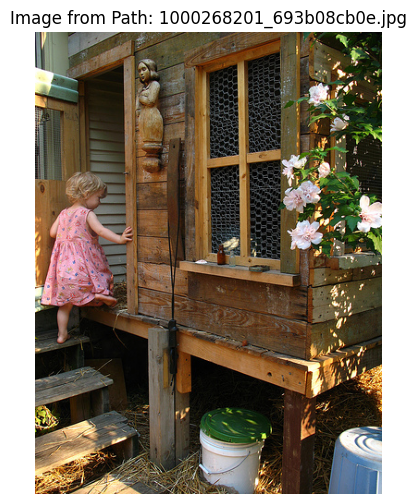

Captions for the image:
1. A child in a pink dress is climbing up a set of stairs in an entry way .
2. A girl going into a wooden building .
3. A little girl climbing into a wooden playhouse .
4. A little girl climbing the stairs to her playhouse .
5. A little girl in a pink dress going into a wooden cabin .


In [62]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


# Path to the image
image_path = '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'

# Filtering the dataframe for the specific image
filtered_captions = df[df['image'] == image_path.split('/')[-1]]['caption']

# Display the image and its captions
try:
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image from Path: " + image_path.split('/')[-1])
    plt.show()
except FileNotFoundError:
    print(f"Image at {image_path} not found. Please ensure the path is correct.")

# Printing captions
print("Captions for the image:")
for idx, caption in enumerate(filtered_captions, start=1):
    print(f"{idx}. {caption}")

In [ ]:
# increased dataset size to 50%
train_combined_model(
    combined_model=combined_model,  # Pass the combined model
    train_loader=train_loader,
    val_loader=val_loader,
    processor=processor,
    optimizer=optimizer,
    device="cuda",
    num_epochs=5,
    save_path="./best_model.pt",
)

In [69]:
import os
from torchvision.transforms.functional import to_pil_image

def generate_first_image_caption(test_loader, combined_model, vanilla_blip_model, processor, device="cuda"):
    """
    Generate captions for the first image in the test loader using both the combined model and the vanilla BLIP model.
    Optionally save the image for visualization.

    Args:
        test_loader: DataLoader for the test dataset.
        combined_model: The trained combined model.
        vanilla_blip_model: The vanilla BLIP model.
        processor: The processor for preprocessing images.
        device: Device to run the models on.

    Returns:
        image_path: Path to the first image for visualization.
        combined_caption: Caption generated by the combined model.
        vanilla_caption: Caption generated by the vanilla BLIP model.
    """
    # Get the first batch
    for batch in test_loader:
        pixel_values = batch[0].to(device)  # Images
        if len(batch) > 2:  # Check if file paths are provided
            file_paths = batch[2]
            image_path = file_paths[0]  # Get the path for the first image
        else:
            image_path = None  # Placeholder if file paths are not available
        break

    image_tensor = pixel_values[0]  # Extract the first image tensor

    # Combined model caption generation
    combined_model.eval()
    with torch.no_grad():
        combined_captions = combined_model.module.generate(pixel_values, max_length=30)  # Already decoded strings
        combined_caption = combined_captions[0]  # Get the caption for the first image

    # Vanilla BLIP model caption generation
    vanilla_blip_model.eval()
    with torch.no_grad():
        vanilla_caption_ids = vanilla_blip_model.generate(pixel_values, max_length=30)
        vanilla_caption = processor.tokenizer.decode(vanilla_caption_ids[0], skip_special_tokens=True)

    # Save the image if path is not available
    if image_path is None:
        output_dir = "./visualized_images"
        os.makedirs(output_dir, exist_ok=True)
        image_path = os.path.join(output_dir, "test_image.jpg")
        to_pil_image(image_tensor.cpu()).save(image_path)

    return image_path, combined_caption, vanilla_caption


# Generate captions for the first image
image_path, combined_caption, vanilla_caption = generate_first_image_caption(
    test_loader=test_loader,
    combined_model=combined_model,
    vanilla_blip_model=vanilla_blip_model,
    processor=processor,
    device="cuda"
)

print("Image Path:", image_path)
print("Combined Model Caption:", combined_caption)
print("Vanilla BLIP Model Caption:", vanilla_caption)


Image Path: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
Combined Model Caption: a small dog running through a field of flowers
Vanilla BLIP Model Caption: a dog running in a field


In [ ]:
Combined Model Caption: a small dog running through a field of flowers
Vanilla BLIP Model Caption: a dog running in a field

In [86]:
img = df['image'].iloc[-50]
img

'2199250692_a16b0c2ae1.jpg'

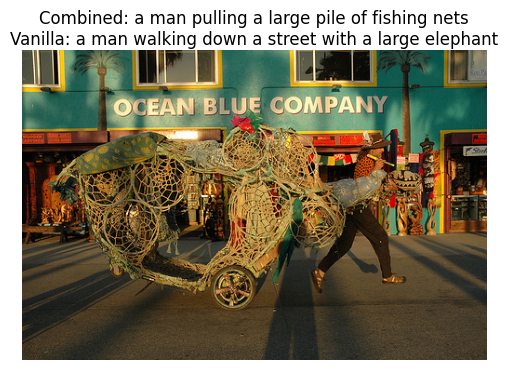

Image Path: /kaggle/input/flickr8k/Images/2199250692_a16b0c2ae1.jpg
Combined Model Caption: a man pulling a large pile of fishing nets
Vanilla BLIP Model Caption: a man walking down a street with a large elephant


In [87]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def generate_and_display_captions(image_path, combined_model, vanilla_blip_model, processor, device="cuda"):
    """
    Generate captions for a given image using both the combined model and the vanilla BLIP model,
    and display the image with captions.

    Args:
        image_path: Path to the image file.
        combined_model: The trained combined model.
        vanilla_blip_model: The vanilla BLIP model.
        processor: The processor for preprocessing images.
        device: Device to run the models on.

    Returns:
        combined_caption: Caption generated by the combined model.
        vanilla_caption: Caption generated by the vanilla BLIP model.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    pixel_values = preprocess(image).unsqueeze(0).to(device)

    # Combined model caption generation
    combined_model.eval()
    with torch.no_grad():
        combined_captions = combined_model.module.generate(pixel_values, max_length=30)  # Already decoded strings
        combined_caption = combined_captions[0]  # Get the caption for the image

    # Vanilla BLIP model caption generation
    vanilla_blip_model.eval()
    with torch.no_grad():
        vanilla_caption_ids = vanilla_blip_model.generate(pixel_values, max_length=30)
        vanilla_caption = processor.tokenizer.decode(vanilla_caption_ids[0], skip_special_tokens=True)

    # Display the image with captions
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Combined: {combined_caption}\nVanilla: {vanilla_caption}", fontsize=12, wrap=True)
    plt.show()

    return combined_caption, vanilla_caption


# Example Usage
image_path = f'/kaggle/input/flickr8k/Images/{img}'  # Provide the path to your image
combined_caption, vanilla_caption = generate_and_display_captions(
    image_path=image_path,
    combined_model=combined_model,
    vanilla_blip_model=vanilla_blip_model,
    processor=processor,
    device="cuda"
)

print("Image Path:", image_path)
print("Combined Model Caption:", combined_caption)
print("Vanilla BLIP Model Caption:", vanilla_caption)

# Research paper and model links:
paper: https://www.researchgate.net/publication/387270932_Semantic_Refinement_and_Visual_Alignment_for_Improved_Image_Captioning

model: https://www.kaggle.com/datasets/aaronmeoded/5-epochs-imagecaptioning5-0